<a href="https://colab.research.google.com/github/colingwuyu/hedgingbox/blob/new_market/new_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install necessary dependencies.
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install QuantLib-Python

In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wGAf7JsNm__-PNif1Y1Gvl4ZiXc1g_xqFpIfbBhDgyRXzgdifqdXBs
Mounted at /content/gdrive


In [1]:
#@title Update HedgingBox
import os
project_folder = '/content/Projects'
hb_source = os.path.join(project_folder, 'HedgingBox')
%mkdir "$project_folder"
%cd "$project_folder"
!pwd
!mkdir -p 'ACME Models/New_Market'
!git clone https://github.com/colingwuyu/HedgingBox.git
%cd HedgingBox
!git fetch --all
!git checkout -b new_market origin/new_market
!git pull
import sys
sys.path.append(hb_source)

mkdir: cannot create directory ‘/content/Projects’: File exists
/content/Projects
/content/Projects
fatal: destination path 'HedgingBox' already exists and is not an empty directory.
/content/Projects/HedgingBox
Fetching origin
fatal: A branch named 'new_market' already exists.
Already up to date.


In [2]:
#@title Import Modules
import acme
import dm_env
from acme import specs
from acme import datasets
from acme import wrappers
from acme.utils.loggers.csv import CSVLogger
from acme.adders import reverb as adders
from acme.tf import savers as tf2_savers
from acme.tf import networks as tf2_networks
from acme import types
from acme.tf import utils as tf2_utils
from acme.tf.losses.distributional import l2_project

import sonnet as snt

import reverb
import trfl

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Mapping, Sequence

import hb
from hb.market_env.market import Market
from hb.market_env.portfolio import Portfolio
from hb.instrument.instrument_factory import InstrumentFactory
from hb.market_env.rewardrules.pnl_reward import PnLReward
from hb.bots.d4pgbot.bot import D4PGBot
from hb.bots.greekbot.bot import GreekHedgeBot 
from hb.market_env.market_test import MarketTest
from hb.market_env.portfolio import Portfolio

from absl import flags

In [4]:
#@title Test Setups
environment_path = "/content/gdrive/My Drive/Projects/New Market/Markets/" #@param {type:"string"}
agent_path = "/content/gdrive/My Drive/Projects/New Market/Agents/" #@param {type:"string"}
market_name = "BSM_SPX_AMZN" #@param {type:"string"}
portfolio_name = "SPX_AMZN_1M_Calls" #@param {type:"string"}
transaction_cost = 0.005 #@param {type:"number"}
portfolio_name = str(transaction_cost*1_000) + "TC " + portfolio_name

In [5]:
#@title BSM Regression Environment
def set_up_regression_bsm_market():
  market = Market(reward_rule=PnLReward(),
                  risk_free_rate=0.02,
                  hedging_step_in_days=1,
                  vol_model='BSM',
                  name=market_name,
                  dir_=environment_path)
  # create instruments
  # --------------------------------------------
  # AMZN
  # --------------------------------------------
  amzn = InstrumentFactory.create(
      f'Stock AMZN 100 10 0 {transaction_cost*100}'
  )
  amzn.set_trading_limit(3.)
  otc_atm_1w_call = InstrumentFactory.create(
                          f'EuroOpt AMZN OTC 1W Call 100.10 30.0 5 (AMZN_OTC_1W_ATM_CALL)'
                      ).underlying(amzn)
  otc_atm_1m_call = InstrumentFactory.create(
                          f'EuroOpt AMZN OTC 4W Call 100.30 30.0 5 (AMZN_OTC_1M_ATM_CALL)'
                      ).underlying(amzn)
  otc_atm_3m_call = InstrumentFactory.create(
                          f'EuroOpt AMZN OTC 3M Call 100.50 30.0 5 (AMZN_OTC_3M_ATM_CALL)'
                      ).underlying(amzn)
  market.calibrate(underlying=amzn,
                    listed_options=otc_atm_3m_call)
  market.add_instruments([otc_atm_1w_call, otc_atm_1m_call, otc_atm_3m_call])
  return wrappers.SinglePrecisionWrapper(market)

In [6]:
#@title BSM SPX AMZN Environment
def set_up_bsm_market():
  market = Market(reward_rule=PnLReward(),
                  risk_free_rate=0.015,
                  hedging_step_in_days=1,
                  vol_model='BSM',
                  name=market_name,
                  dir_=environment_path)
  # create instruments
  # --------------------------------------------
  # AMZN
  # --------------------------------------------
  amzn = InstrumentFactory.create(
      'Stock AMZN 100 25 0 0.15'
  )
  amzn.set_trading_limit(1.5)
  otc_atm_1m_call = InstrumentFactory.create(
                          f'EuroOpt AMZN OTC 4W Call 100 39.84 5 (AMZN_OTC_1M_ATM_CALL)'
                      ).underlying(amzn)
  market.calibrate(underlying=amzn,
                    listed_options=otc_atm_1m_call)
  market.add_instruments([otc_atm_1m_call])    
  # --------------------------------------------
  # SPX
  # --------------------------------------------
  spx = InstrumentFactory.create(
      'Stock SPX 100 10 1.92 0.5'
  )
  spx.set_trading_limit(1.5)
  otc_atm_1m_call = InstrumentFactory.create(
                          f'EuroOpt SPX OTC 4W Call 100 25.77 3.5 (SPX_OTC_1M_ATM_CALL)'
                      ).underlying(spx)
  market.calibrate(underlying=spx,
                    listed_options=otc_atm_1m_call)
  market.add_instruments([otc_atm_1m_call])            
  return wrappers.SinglePrecisionWrapper(market)

In [7]:
#@title BSM Regression Environment Setup
initial_stock_holding = 1.5 #@param {type:"number"}
initial_call_holding = -3 #@param {type:"number"}
market = set_up_bsm_market()
portfolio = Portfolio.make_portfolio(
            instruments=market.get_instruments([
                                                'AMZN', 'SPX',
                                                'AMZN_OTC_1M_ATM_CALL',
                                                'SPX_OTC_1M_ATM_CALL'
                                                ]),
            holdings=[initial_stock_holding, 
                      initial_stock_holding,
                      initial_call_holding,
                      initial_call_holding],
            name=portfolio_name
        )
market.init_portfolio(portfolio)

In [8]:
def make_networks(
    action_spec: specs.BoundedArray,
    policy_layer_sizes: Sequence[int] = (256, 256, 256),
    critic_layer_sizes: Sequence[int] = (512, 512, 256),
    vmin: float = -150.,
    vmax: float = 150.,
    num_atoms: int = 51,
) -> Mapping[str, types.TensorTransformation]:
  """Creates networks used by the agent."""

  # Get total number of action dimensions from action spec.
  num_dimensions = np.prod(action_spec.shape, dtype=int)

  # Create the shared observation network; here simply a state-less operation.
  observation_network = tf2_utils.batch_concat

  # Create the policy network.
  policy_network = snt.Sequential([
      tf2_networks.LayerNormMLP(policy_layer_sizes, activate_final=True),
      tf2_networks.NearZeroInitializedLinear(num_dimensions),
      tf2_networks.TanhToSpec(action_spec),
  ])

  # Create the critic network.
  critic_network = snt.Sequential([
      # The multiplexer concatenates the observations/actions.
      tf2_networks.CriticMultiplexer(),
      tf2_networks.LayerNormMLP(critic_layer_sizes, activate_final=True),
      tf2_networks.DiscreteValuedHead(vmin, vmax, num_atoms),
  ])

  return {
      'policy': policy_network,
      'critic': critic_network,
      'observation': observation_network,
  }

In [9]:
#@title Create D4PG Hedging Bot
#@markdown ###Replay Buffer Param
batch_size =  256#@param {type:"integer"}
samples_per_insert =  32#@param {type:"integer"}
#@markdown ###Prediction Param
num_prediction_episodes =  1000#@param {type:"integer"}
train_episodes_per_pred =  1000#@param {type:"integer"}
model_name = market_name + "/" + portfolio_name
create_new_model = False #@param {type:"boolean"}
risk_obj_func = True #@param {type:"boolean"}
risk_obj_c = 1.5 #@param {type:"number"}
model_path = f"{agent_path}{model_name}/"
if not os.path.exists(model_path):
  os.makedirs(model_path)
model_chkpt = model_path + "checkpoint" 
if not os.path.exists(model_chkpt):
  os.makedirs(model_chkpt)
spec = specs.make_environment_spec(market)
d4pg_networks = make_networks(spec.actions)

d4pg_bot = D4PGBot(
    environment_spec=spec,
    policy_network=d4pg_networks['policy'],
    critic_network=d4pg_networks['critic'],
    risk_obj_func=risk_obj_func,
    risk_obj_c=risk_obj_c,
    batch_size=batch_size,
    samples_per_insert=samples_per_insert,
    pred_episode=num_prediction_episodes,
    observation_per_pred=train_episodes_per_pred,
    pred_dir=model_path,
    checkpoint_subpath=model_path,
    checkpoint_per_min=30.
    )
d4pg_bot._checkpointer.save(force=True)

True

In [10]:
#@title D4PG Bot Train & Prediction
d4pg_bot._actor._actor._adder.reset()
num_episodes =  train_episodes_per_pred + num_prediction_episodes
num_check_points =  20#@param {type:"integer"}
learning_rate =  1e-4#@param {type:"number"}
norm_sig = 0.3 #@param {type:"number"}
prediction = True #@param {type:"boolean"}

# update learning rate
d4pg_bot._learner._policy_optimizer.learning_rate = learning_rate
d4pg_bot._learner._critic_optimizer.learning_rate = learning_rate
# update exploration epsilon
d4pg_bot._actor._actor._policy_network = tf.function(
    snt.Sequential([
            d4pg_bot._learner._observation_network,
            d4pg_bot._learner._policy_network,
            tf2_networks.ClippedGaussian(norm_sig),
            tf2_networks.ClipToSpec(spec.actions),
        ])
)
d4pg_bot.set_pred_only(prediction)
if prediction:
  num_check_points = 1
# Try running the environment loop. We have no assertions here because all
# we care about is that the agent runs without raising any errors.
if num_episodes > 0:
  for i in range(num_check_points):
    print(f"Check Point {i}")
    # train
    loop = acme.EnvironmentLoop(market, d4pg_bot)
    if not prediction:
      market.set_pred_mode(False)
      loop.run(num_episodes=train_episodes_per_pred)
    # prediction
    market.set_pred_mode(True)
    market.set_pred_episodes(num_prediction_episodes)
    loop.run(num_episodes=market.get_pred_episodes())

Check Point 0
[Environment Loop] Episode Length = 30 | Episode Return = -3.407 | Episodes = 7 | Steps = 210 | Steps Per Second = 358.950
[Environment Loop] Episode Length = 30 | Episode Return = -0.224 | Episodes = 16 | Steps = 480 | Steps Per Second = 139.738
[Environment Loop] Episode Length = 30 | Episode Return = -7.413 | Episodes = 25 | Steps = 750 | Steps Per Second = 372.217
[Environment Loop] Episode Length = 30 | Episode Return = 3.965 | Episodes = 34 | Steps = 1020 | Steps Per Second = 333.483
[Environment Loop] Episode Length = 30 | Episode Return = -6.611 | Episodes = 42 | Steps = 1260 | Steps Per Second = 140.487
[Environment Loop] Episode Length = 30 | Episode Return = -1.593 | Episodes = 52 | Steps = 1560 | Steps Per Second = 342.604
[Environment Loop] Episode Length = 30 | Episode Return = -2.018 | Episodes = 61 | Steps = 1830 | Steps Per Second = 125.875
[Environment Loop] Episode Length = 30 | Episode Return = 1.256 | Episodes = 70 | Steps = 2100 | Steps Per Second = 

In [11]:
d4pg_bot.get_predictor()._update_progress_figures()
status = d4pg_bot.get_predictor()._progress_measures
print("D4PG Bot PnL mean-var %s" % str(status['mean-var']))
print("D4PG Bot PnL mean %s" % str(status['pnl_mean']))
print("D4PG Bot PnL std %s" % str(status['pnl_std']))
print("D4PG Bot 95VaR %s" % status['pnl_95VaR'])
print("D4PG Bot 99VaR %s" % status['pnl_99VaR'])
print("D4PG Bot 95CVaR %s" % status['pnl_95CVaR'])
print("D4PG Bot 99CVaR %s" % status['pnl_99CVaR'])
d4pg_hedge_perf = pd.read_csv(f'{model_path}logs/d4pg_predictor/performance/logs.csv')
d4pg_hedge_pnl_list = d4pg_hedge_perf[d4pg_hedge_perf.type=='pnl'].drop(['path_num','type'], axis=1).sum(axis=1).values
np.save(f'{model_path}d4pg_hedge_pnl_measures.npy', d4pg_hedge_pnl_list)

status_dic = {}

for k in status.keys():
  status_dic[k] = [status[k]]

pd.DataFrame.from_dict(status_dic, orient="index", columns=["drl"]).to_csv(f'{model_path}drl_pnl_stat.csv')

D4PG Bot PnL mean-var -8.878363518780118
D4PG Bot PnL mean -3.9011989013552304
D4PG Bot PnL std 3.318109744949925
D4PG Bot 95VaR -9.298436182772274
D4PG Bot 99VaR -11.647203885968773
D4PG Bot 95CVaR -10.64677170814597
D4PG Bot 99CVaR -12.64366634740727


In [12]:
#@title GreekHedge Bot
market.set_pred_mode(True)
market.set_pred_episodes(num_prediction_episodes)
spec = specs.make_environment_spec(market)

# Construct the agent.
agent = GreekHedgeBot(
    portfolio=portfolio,
    use_bs_delta=True,
    environment_spec=spec,
    pred_dir = model_path
)
# Try running the environment loop. We have no assertions here because all
# we care about is that the agent runs without raising any errors.
loop = acme.EnvironmentLoop(market, agent)
loop.run(num_episodes=market.get_pred_episodes())
agent.get_predictor()._update_progress_figures()
status = agent.get_predictor()._progress_measures
print("Greek Bot PnL mean-var %s" % str(status['mean-var']))
print("Greek Bot PnL mean %s" % str(status['pnl_mean']))
print("Greek Bot PnL std %s" % str(status['pnl_std']))
print("Greek Bot 95VaR %s" % status['pnl_95VaR'])
print("Greek Bot 99VaR %s" % status['pnl_99VaR'])
print("Greek Bot 95CVaR %s" % status['pnl_95CVaR'])
print("Greek Bot 99CVaR %s" % status['pnl_99CVaR'])
greek_hedge_perf = pd.read_csv(f'{model_path}logs/greek_hedge_predictor/performance/logs.csv')
greek_hedge_pnl_list = greek_hedge_perf[greek_hedge_perf.type=='pnl'].drop(['path_num','type'], axis=1).sum(axis=1).values
np.save(f'{model_path}greek_hedge_pnl_measures.npy', greek_hedge_pnl_list)

status_dic = {}

for k in status.keys():
  status_dic[k] = [status[k]]

pd.DataFrame.from_dict(status_dic, orient="index", columns=["greek"]).to_csv(f'{model_path}greek_pnl_stat.csv')

[Environment Loop] Episode Length = 30 | Episode Return = -3.459 | Episodes = 13 | Steps = 390 | Steps Per Second = 165.255
[Environment Loop] Episode Length = 30 | Episode Return = -7.974 | Episodes = 26 | Steps = 780 | Steps Per Second = 616.405
[Environment Loop] Episode Length = 30 | Episode Return = -3.421 | Episodes = 40 | Steps = 1200 | Steps Per Second = 629.738
[Environment Loop] Episode Length = 30 | Episode Return = -9.108 | Episodes = 53 | Steps = 1590 | Steps Per Second = 666.644
[Environment Loop] Episode Length = 30 | Episode Return = -12.042 | Episodes = 66 | Steps = 1980 | Steps Per Second = 663.306
[Environment Loop] Episode Length = 30 | Episode Return = -4.176 | Episodes = 79 | Steps = 2370 | Steps Per Second = 651.306
[Environment Loop] Episode Length = 30 | Episode Return = -6.824 | Episodes = 92 | Steps = 2760 | Steps Per Second = 156.553
[Environment Loop] Episode Length = 30 | Episode Return = -4.233 | Episodes = 105 | Steps = 3150 | Steps Per Second = 162.333


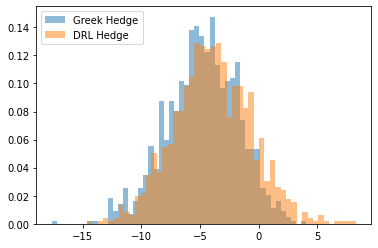

In [13]:
#@title Plot PnL Distribution
greek_hedge_pnl_list = np.load(f'{model_path}greek_hedge_pnl_measures.npy')
d4pg_hedge_pnl_list = np.load(f'{model_path}d4pg_hedge_pnl_measures.npy')
plt.hist(greek_hedge_pnl_list, bins=50, alpha=0.5, label='Greek Hedge', density=True)
plt.hist(d4pg_hedge_pnl_list, bins=50, alpha=0.5, label='DRL Hedge', density=True)
plt.legend(loc='upper left')
plt.savefig(f'{model_path}pnl_dist.png')
plt.show()

In [38]:
def path_plot(delta_pnl, d4pg_pnl, delta_action, d4pg_action, hedging_price, derivative_price, figure_name):
  hedging_dim = hedging_price.shape[0]
  derivative_dim = derivative_price.shape[0]
  step_dim = hedging_price.shape[1]
  d4pg_cum_pnl = np.cumsum(pd.to_numeric(d4pg_pnl))
  delta_cum_pnl = np.cumsum(pd.to_numeric(delta_pnl))
  d4pg_cum_holding = np.cumsum(d4pg_action, axis=1) + initial_stock_holding
  delta_cum_holding = np.cumsum(delta_action, axis=1) + initial_stock_holding

  num_sub_plts = 2+2*hedging_dim
  fig, axs = plt.subplots(num_sub_plts, 1,figsize=(num_sub_plts*10,10))
  for i in range(hedging_dim):
    axs[0].plot(hedging_price[i,:], label=f'Hedging Instrument {i}')
  axs[0].grid(True)
  axs[0].set_ylabel('Hedging Instrument Prices')
  ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
  ax2.set_ylabel('Derivative Prices') 
  for i in range(derivative_dim): 
    ax2.plot(derivative_price[i,:], label=f'Liability {i}')
  axs[0].legend(loc='upper left')
  ax2.legend(loc='lower left')

  for i in range(hedging_dim):
    axs[1+i*2].bar(range(0, step_dim), d4pg_action[i,:], alpha=0.5, label='D4PG bot hedging action')
    axs[1+i*2].bar(range(0, step_dim), delta_action[i,:], alpha=0.5, label='Delta bot hedging action')
    axs[1+i*2].legend(loc='upper left')
    axs[1+i*2].set_ylabel(f'Hedging {i} Action')

    axs[2+i*2].bar(range(0, step_dim), d4pg_cum_holding[i,:], alpha=0.5, label='D4PG bot hedging holding')
    axs[2+i*2].bar(range(0, step_dim), delta_cum_holding[i,:], alpha=0.5, label='Delta bot hedging holding')
    axs[2+i*2].legend(loc='upper left')
    axs[2+i*2].set_ylabel(f'Hedging {i} Holding')

  axs[1+2*hedging_dim].plot(d4pg_cum_pnl, label='D4PG bot accumulative P&L')
  axs[1+2*hedging_dim].plot(delta_cum_pnl, label='Delta bot accumulative P&L')
  axs[1+2*hedging_dim].grid(True)
  axs[1+2*hedging_dim].legend(loc='upper left')
  axs[1+2*hedging_dim].set_xlabel('time')

  fig.tight_layout()
  plt.savefig(f'{model_path}price_action_path_{figure_name}.png')
  plt.show()

# Covid19 Stress Testing

In [31]:
#@title Stress Testing
scenario_name = "Covid19" #@param {type:"string"}
market.load_scenario(scenario_name)
loop = acme.EnvironmentLoop(market, agent)
loop.run(num_episodes=market.get_pred_episodes())
market.load_scenario(scenario_name)
loop = acme.EnvironmentLoop(market, d4pg_bot)
loop.run(num_episodes=market.get_pred_episodes())

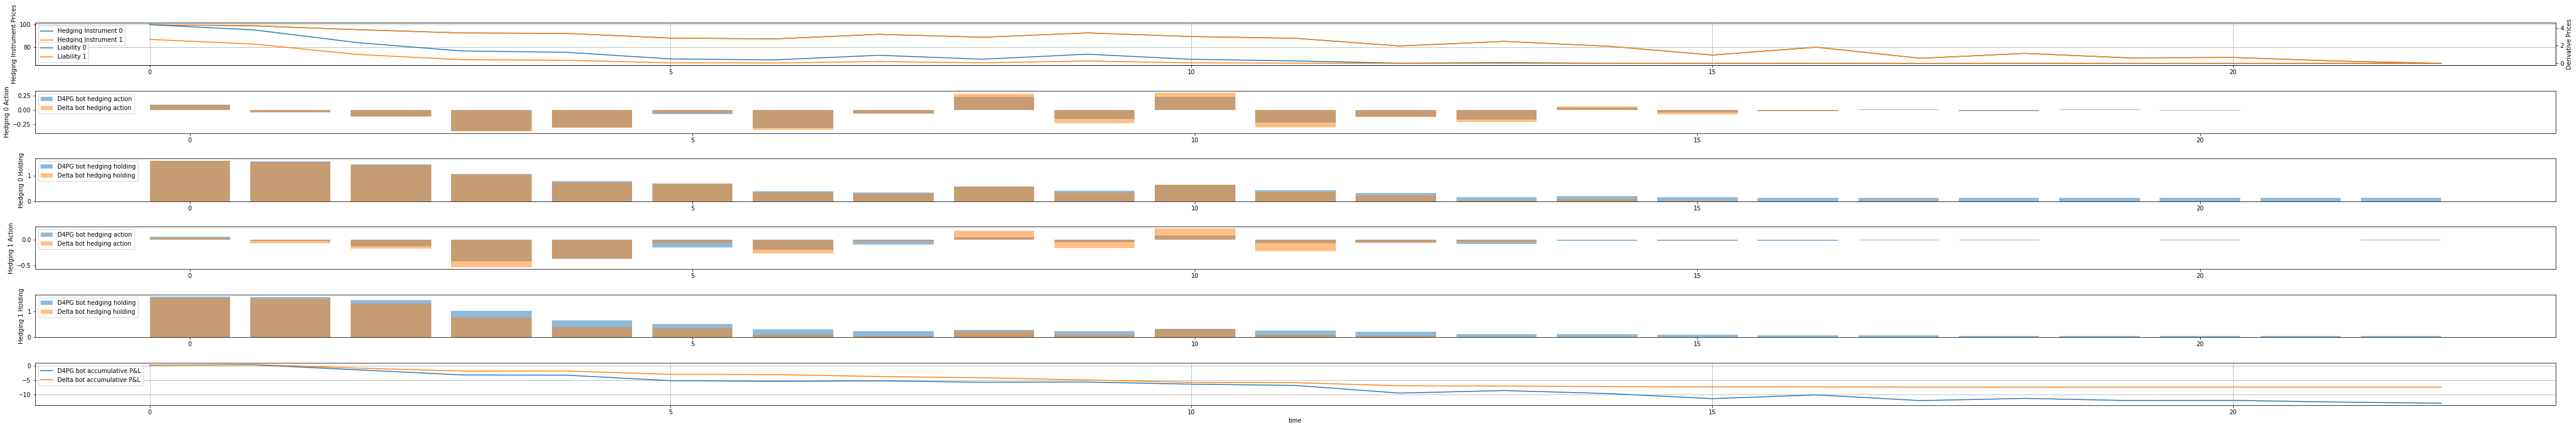

In [39]:
greek_predictor = agent.get_predictor()
d4pg_predictor = d4pg_bot.get_predictor()
greek_stress_pnl = greek_predictor.get_episode_pnl_path()
greek_hedging_price = greek_predictor.get_episode_hedging_price()
greek_derivative_price = greek_predictor.get_episode_derivative_price()
greek_actions = greek_predictor.get_episode_action()
d4pg_stress_pnl = d4pg_predictor.get_episode_pnl_path()
d4pg_actions = d4pg_predictor.get_episode_action()
d4pg_hedging_price = d4pg_predictor.get_episode_hedging_price()
d4pg_derivative_price = d4pg_predictor.get_episode_derivative_price()
path_plot(greek_stress_pnl, d4pg_stress_pnl, greek_actions, d4pg_actions, greek_hedging_price, greek_derivative_price, scenario_name)

In [40]:
print(f"Greek Hedging P&L: {np.sum(greek_stress_pnl)}")
print(f"D4PG Hedging P&L: {np.sum(d4pg_stress_pnl)}")

Greek Hedging P&L: -7.407338671764592
D4PG Hedging P&L: -13.073263935744762
